In [1]:
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# US Consumer FInancial Protection Bureau

As an intermediary, the CFPB receives a large number of complaints. To help the CFPB better manage them, they would like to reduce the complaints logged to those that are most likely to be successful. To help them to do this, they would like to be able to indicate to a consumer whether it is likely that their complaint will be accepted. This will help the consumer to decide whether they wish to go through the complaints process, and will reduce the number of complaints logged.

Therefore, your objective is to build a classification model that can be used to:

   1. Determine whether a consumer's complaint will be accepted and whether they are likely to receive relief.
   2. Help the CFPB understand what factors affect how a company responds to the complaints that it receives.
   
This investigation is split into three sections:

### [Exploratory Data Analysis](#eda)

### [Classification](#clf)

### [Conclusion](#fin)

<a id='eda'></a>

## Exploratory Data Analysis

In this section, we perform some basic data cleaning, and plot the data to understand some of the features.

In [1]:
## if you haven't got the data, you can download it from here
## I've inluded a sample in this repo, just so you can see the code running

In [2]:
df = pd.read_csv('Consumer_complaints.csv')

In [3]:
df.columns = [c.replace(' ','_').lower().replace('-','').replace('?','') for c in df.columns]
df.columns

Index(['date_received', 'product', 'subproduct', 'issue', 'subissue',
       'consumer_complaint_narrative', 'company_public_response', 'company',
       'state', 'zip_code', 'tags', 'consumer_consent_provided',
       'submitted_via', 'date_sent_to_company', 'company_response_to_consumer',
       'timely_response', 'consumer_disputed', 'complaint_id'],
      dtype='object')

In [4]:
def extract_year_month_date(datetime_series, dateformat=None, is_string=False):
    ## take a datetime series and return a dataframe containing the year, month, 
    ## day and dayofweek
    if dateformat is None:
        infer_date_format = True
    else:
        infer_date_format = False
    
    if is_string:
        datetime_series = pd.to_datetime(datetime_series, infer_datetime_format=infer_date_format, format=dateformat)
#         print(datetime_series)
    colname = datetime_series.name
    year = datetime_series.apply(lambda x: x.year).to_frame().\
                           rename(columns = {colname:'year_{}'.format(colname)})
    month = datetime_series.apply(lambda x: x.month).to_frame().\
                            rename(columns = {colname:'month_{}'.format(colname)})
    day = datetime_series.apply(lambda x: x.day).to_frame().\
                          rename(columns = {colname:'day_{}'.format(colname)})
    dayofweek = datetime_series.apply(lambda x: x.dayofweek).to_frame().\
                                rename(columns = {colname:'dayofweek_{}'.format(colname)})
    return year.join(month).join(day).join(dayofweek).astype(int)

df = df.join(extract_year_month_date(df['date_received'], is_string=True, dateformat="%d/%M/%Y"))
df = df.join(extract_year_month_date(df['date_sent_to_company'], is_string=True, dateformat="%d/%M/%Y"))

In [5]:
# Look at the total complaints for different products, by year 
pd.crosstab(df['product'], df.year_date_received)

year_date_received,2011,2012,2013,2014,2015,2016,2017
product,,,,,,,
Bank account or service,0,12212,13388,14662,17140,21849,6956
Checking or savings account,0,0,0,0,0,0,9947
Consumer Loan,0,1986,3117,5457,7888,9602,3558
Credit card,1260,15353,13105,13974,17300,21066,7132
Credit card or prepaid card,0,0,0,0,0,0,11921
Credit reporting,0,1873,14380,29239,34273,44081,16578
"Credit reporting, credit repair services, or other personal consumer reports",0,0,0,0,0,0,59186
Debt collection,0,0,11069,39148,39757,40492,41101
"Money transfer, virtual currency, or money service",0,0,0,0,0,0,2213


In [6]:
## looking at the list of products, we can see that there's some unification which seems reasonable.

remap_products = {
     # product:remapped_product
    'Credit card':'Credit card or prepaid card',
    'Credit reporting, credit repair services, or other personal consumer reports':'Credit reporting',
    'Money transfers':'Money transfer, virtual currency, or money service',
    'Virtual currency':'Money transfer, virtual currency, or money service',
    'Payday loan, title loan, or personal loan':'Payday loan',
    'Prepaid card':'Credit card or prepaid card', 
    
}

df['product'] = df['product'].apply(lambda x: remap_products.get(x) if remap_products.get(x) else x)

In [7]:
# unify the relief responses
relief = ['Closed with monetary relief',
             'Closed with non-monetary relief',
             'Closed with relief']

df['relief_received'] = df.company_response_to_consumer.apply(lambda x:1 if x in relief else 0)

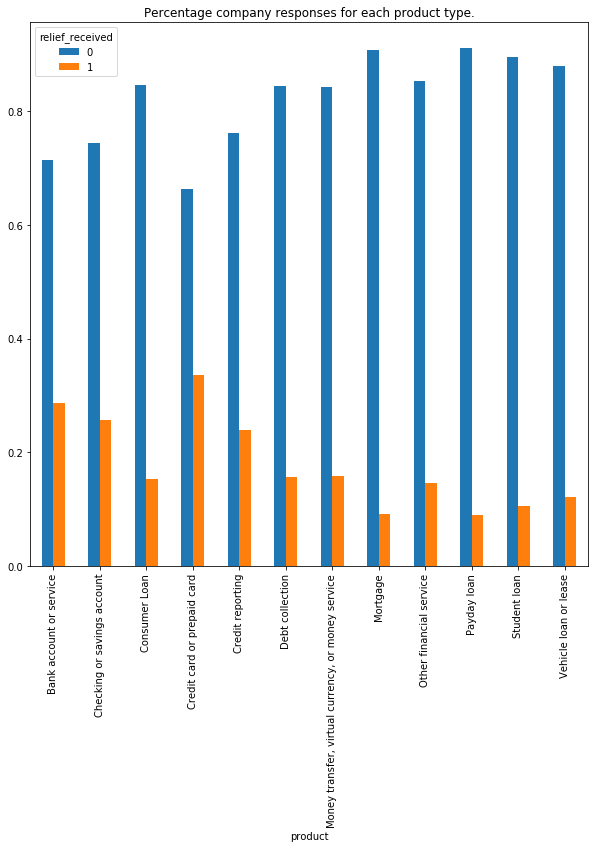

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
tab = pd.crosstab(df['product'],df['relief_received'])
(tab.T / tab.sum(axis=1)).T.plot(kind='bar', ax=ax)
plt.title('Percentage company responses for each product type.')
# plt.tight_layout()

plt.show()

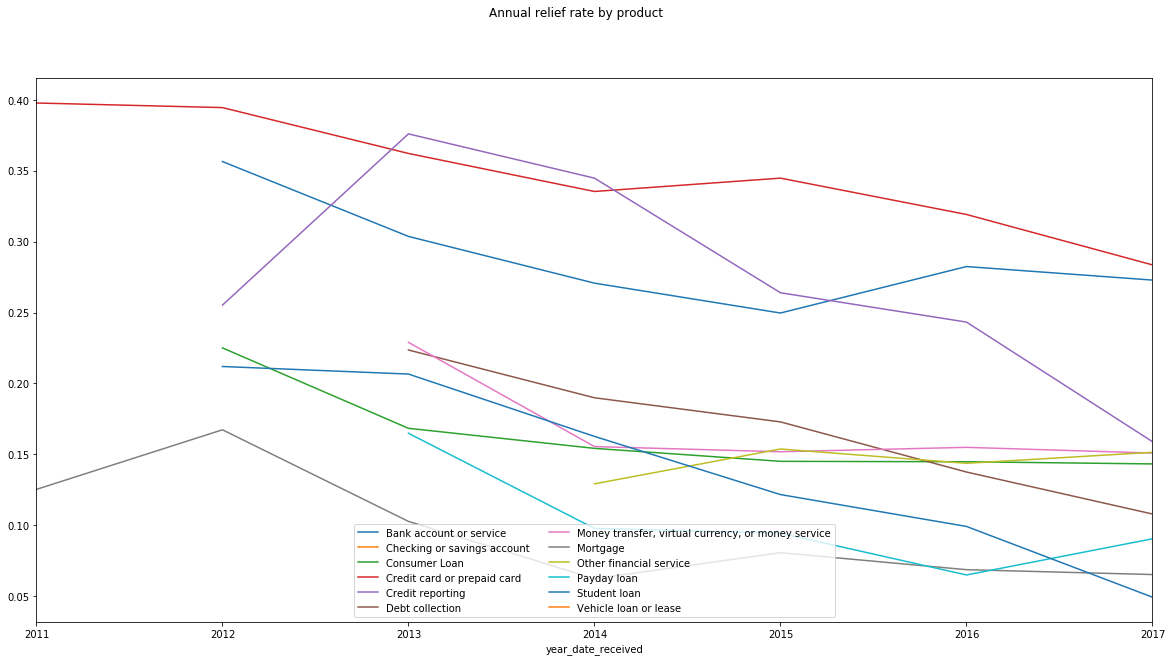

In [9]:
fig, ax = plt.subplots(figsize=(20,10))

df.groupby(['year_date_received','product']).relief_received.mean().unstack().plot(ax=ax)
plt.legend(loc='lower center', ncol=2)
plt.suptitle('Annual relief rate by product')
plt.show()

#### Company size
We observe that most companies have a very small number of complaints, while others have a very large number. Does this affect the relief rate?

In [10]:
print(\
      "{0:.1f}% of companies do less than 100 transactions.".format(\
      (df.groupby('company').count()['product'] < 100).sum() /\
                            df.company.nunique() * 100))

89.4% of companies do less than 100 transactions.


In [11]:
# we note that most companies are very small
company_size = df.groupby('company').count()['product']
company_size_bin = pd.cut(company_size, bins=[0, 100, 1000, 10000, 50000, 100000],
                          labels=['very_small', 'small', 'medium', 'large', 'very_large']).reset_index()
company_size_bin.columns = ['company', 'company_size']
df = df.merge(company_size_bin, on='company')

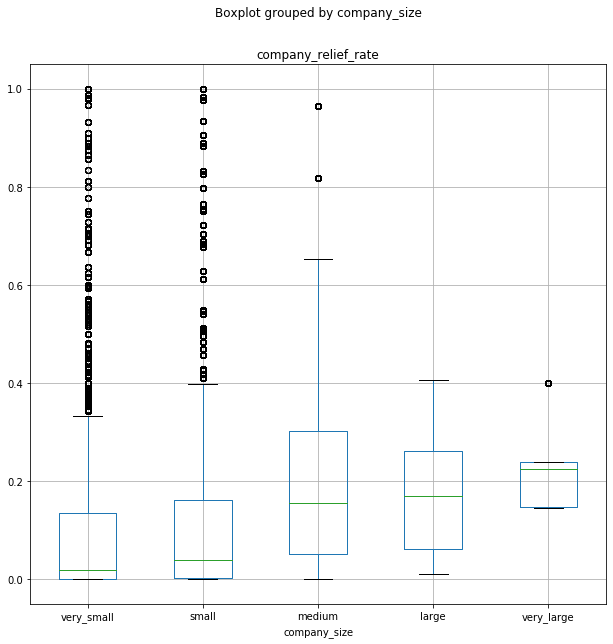

In [12]:
df['company_relief_rate'] = df.groupby('company').relief_received.transform('mean')

fig, ax = plt.subplots(figsize=(10,10))
df.boxplot(column='company_relief_rate', by='company_size',ax=ax)
plt.show()

In [13]:
# We can see that very large companies receive most complaints about bank accounts, credit reporting, and mortgages
pd.crosstab(df['product'], df['company_size'])

company_size,very_small,small,medium,large,very_large
product,,,,,
Bank account or service,1000,6115,30471,21322,27299
Checking or savings account,169,655,3625,2559,2939
Consumer Loan,2792,9735,11308,4441,3332
Credit card or prepaid card,572,3801,27592,58072,14893
Credit reporting,1942,5515,5512,3934,182707
Debt collection,36514,58364,57402,15051,4236
"Money transfer, virtual currency, or money service",395,831,4960,635,764
Mortgage,7786,15079,58160,87537,73632
Other financial service,324,182,263,149,141


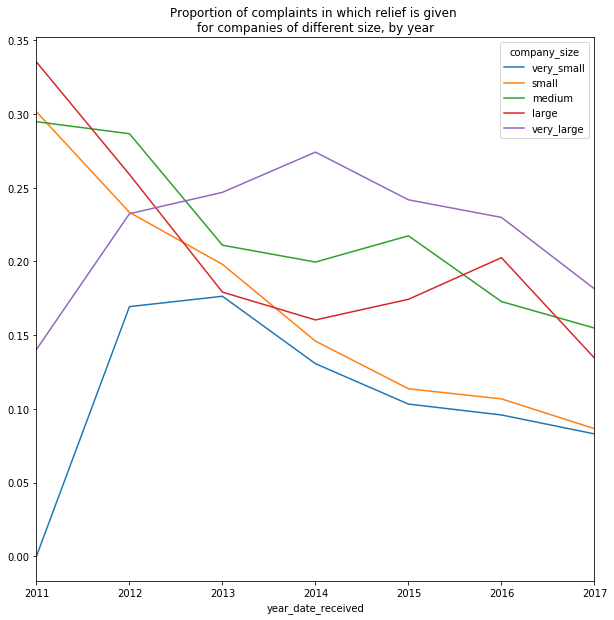

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
df.groupby(['year_date_received','company_size']).relief_received.mean().unstack().plot(ax=ax)
plt.title('Proportion of complaints in which relief is given \nfor companies of different size, by year')
plt.show()

## Discussion of exploratory data analysis

From the exploratory analysis above, we can make a few initial observations:
- Credit cards and prepaid cards, credit reporting, and account services have the highest relief rates, but these are gradually decreasing year-on-year
- Larger companies have a higher average relief rate, but there is much greater variation in small companies.

<a id='clf'></a>

# Classification

In this task, we are asked to build a classification model that can be used to:

   1. Determine whether a consumer's complaint will be accepted and whether they are likely to receive relief.
   2. Help the CFPB understand what factors affect how a company responds to the complaints that it receives.
    
From this statement, we can begin to make plans about what sort of model to use in classification:
- an interpretable model will be helpful as we will immediately gain an insight into factors affecting company response
- if the model is not interpretable, we will need to use some kind of model inspection or explanation technique
- Relevant factors may be found in the text, but also in the metadata of the complaint (product, issue, tag etc.) so we should also include these features in our model.

#### Baseline
In any classification problem, it's useful to establish a baseline for further development, and for nlp problems this is usually a bag-of-words input with a linear model - here we will try Logistic Regression, and a Linear SVC. 


#### Data preprocessing
It is standard practice to undertake some cleaning of the text, such as removing stopwords and punctuation; from a brief glance at some samples, we can see that the complaints are anonymised using 'xxxx' tokens - these should also be removed. As mentioned above, a bag-of-words model is a standard approach, but we can also use Tf-Idf to give a relevance weighting to tokens within the text. 

The following metadata features will also be included: product, issue, sub-issue, company size and tag. We will not include the actual company, as this may lead to overfitting based on the relief rate of companies in the training set, and would not generalise to new companies as they appear in the data.

There is a 4:1 imbalance in the data, which is not too extreme, but should be accounted for. As a minimum, the data must be stratified in the train-test split, and during model development we can explore the use of class weights and oversampling of the data.


In [19]:
df.dropna(subset=['consumer_complaint_narrative'])\
  .relief_received.value_counts() / df.dropna(subset=['consumer_complaint_narrative']).shape[0]

0    0.819553
1    0.180447
Name: relief_received, dtype: float64

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
import scipy.stats as stats
np.random.seed(31415)


In [40]:
df_text = df.copy()
df_text.dropna(axis=0,subset=['consumer_complaint_narrative'], inplace=True)
df_text.shape
X = df_text['consumer_complaint_narrative'].str.replace('xx+','')
y = df_text.relief_received
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=31415)


In [41]:
# baseline model for logistic regression and LinearSVC
relief_tags = ['Closed with non-monetary relief',
       'Closed with monetary relief','Closed with relief',]


vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                max_df = 0.5, 
                                min_df = 100)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

models = {'lr':LogisticRegression(class_weight={0:1,1:5}, random_state=31415), 
          'svc':LinearSVC(class_weight={0:1,1:5}, random_state=31415)}
preds = {}

for name, model in models.items():
    print(name)
    model.fit(X_train, y_train)
    preds[name] = model.predict(X_test)
    print(classification_report(y_test, preds[name]))


lr


C:\Users\thomas.merritt-smith\AppData\Local\Continuum\anaconda3\envs\uscfpb_test\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.91      0.66      0.77     32777
           1       0.31      0.69      0.43      7217

    accuracy                           0.67     39994
   macro avg       0.61      0.68      0.60     39994
weighted avg       0.80      0.67      0.71     39994

svc
              precision    recall  f1-score   support

           0       0.89      0.74      0.81     32777
           1       0.33      0.59      0.42      7217

    accuracy                           0.71     39994
   macro avg       0.61      0.66      0.62     39994
weighted avg       0.79      0.71      0.74     39994



C:\Users\thomas.merritt-smith\AppData\Local\Continuum\anaconda3\envs\uscfpb_test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


#### Leveraging additional meta-data

In [42]:
from scipy.sparse import hstack

ohe = OneHotEncoder(handle_unknown='ignore')
# we won't use company name, as this would lead to overfitting to individual companies
features = ['product','issue','subissue','company_size'] 

X = df_text[['product','issue','subissue','company_size','consumer_complaint_narrative']]
X[['product','issue','subissue']] = X[['product','issue','subissue']].fillna('none')
y = df_text.relief_received
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=31415)

vectorizer_meta_data = CountVectorizer()
X_train_text = vectorizer_meta_data.fit_transform(X_train['consumer_complaint_narrative'])
X_test_text = vectorizer_meta_data.transform(X_test['consumer_complaint_narrative'])
X_train_features = ohe.fit_transform(X_train[features],)
X_test_features = ohe.transform(X_test[features])

X_train = hstack([X_train_text, X_train_features])
X_test = hstack([X_test_text, X_test_features])




C:\Users\thomas.merritt-smith\AppData\Local\Continuum\anaconda3\envs\uscfpb_test\lib\site-packages\pandas\core\frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [43]:
model = LogisticRegression(class_weight='balanced', random_state=31415)
model.fit(X_train, y_train)

C:\Users\thomas.merritt-smith\AppData\Local\Continuum\anaconda3\envs\uscfpb_test\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=31415, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.91      0.72      0.80     32777
           1       0.34      0.66      0.45      7217

    accuracy                           0.71     39994
   macro avg       0.62      0.69      0.63     39994
weighted avg       0.80      0.71      0.74     39994



#### Inspecting the Logistic Regression model

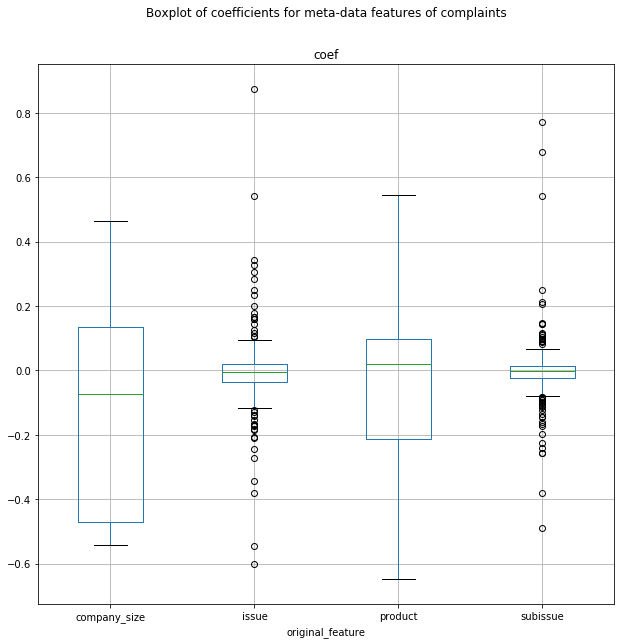

In [45]:
feature_melt = []
for feature, categories in zip(features,ohe.categories_):
    melted = [feature] * len(categories)
    feature_melt += melted

categories = np.hstack(ohe.categories_)

coef_df = pd.DataFrame([categories, model.coef_[:,-len(categories):][0], feature_melt]).T
coef_df.columns = ['category', 'coef', 'original_feature']

fig, ax = plt.subplots(figsize=(10,10))
coef_df.boxplot(column='coef', 
           by='original_feature', 
           ax=ax,
           )
plt.suptitle('Boxplot of coefficients for meta-data features of complaints')
plt.show()

In [46]:
# Display the coefficients for products
coef_df[coef_df.original_feature == 'product'].sort_values('coef', ascending=False)

,category,coef,original_feature
3,Credit card or prepaid card,0.545969,product
0,Bank account or service,0.326113,product
1,Checking or savings account,0.225128,product
5,Debt collection,0.0556301,product
8,Other financial service,0.0510896,product
2,Consumer Loan,0.0438741,product
11,Vehicle loan or lease,-0.001235,product
4,Credit reporting,-0.0166776,product
6,"Money transfer, virtual currency, or money ser...",-0.156185,product
9,Payday loan,-0.386861,product


In [47]:
# Display the coefficients for company size
coef_df[coef_df.original_feature == 'company_size'].sort_values('coef', ascending=False)

,category,coef,original_feature
381,very_large,0.463117,company_size
379,medium,0.136443,company_size
378,large,-0.073706,company_size
382,very_small,-0.471874,company_size
380,small,-0.542694,company_size


In [48]:
# Display the coefficients for issues
coef_df[coef_df.original_feature == 'issue'].sort_values('coef', ascending=False)[:10]

,category,coef,original_feature
156,Unable to get credit report/credit score,0.875798,issue
134,Problems caused by my funds being low,0.542986,issue
87,Late fee,0.3429,issue
46,Communication tactics,0.326751,issue
159,Unauthorized transactions/trans. issues,0.305247,issue
80,Improper contact or sharing of info,0.284458,issue
101,"Managing, opening, or closing account",0.250215,issue
108,Other fee,0.233449,issue
30,Billing disputes,0.198935,issue
56,Credit monitoring or identity protection,0.177035,issue


In [49]:
words = vectorizer.get_feature_names()
word_coefs = pd.DataFrame([words, models['lr'].coef_[0]]).T
word_coefs.columns = ['words','coef']


In [50]:
# Display the words with largest positive coefficients
print(word_coefs.sort_values('coef', ascending=False)[:60])

                   words      coef
2844           jefferson   2.72214
1829             dynamic   2.29037
4377            rushcard   1.91164
1920            enhanced   1.57078
2789          interstate    1.4535
4376                rush    1.3884
3837       professionals  0.830137
1096            citigold  0.801865
5132           universal  0.792687
562   annualcreditreport  0.776771
3585            partners   0.68735
520               allied  0.623358
1019                cbna  0.613705
2586           hurricane   0.58328
1265                conn  0.560628
1256         conflicting  0.557217
4885          technology  0.530956
4185              repaye  0.526669
2435               guide  0.525563
1037       certification  0.522281
3318               multi  0.518445
281                  809  0.499301
548         amortization  0.497155
3485          operations  0.495929
1212          completing  0.493841
715             attitude  0.491621
1016             cavalry   0.48636
4607              so

In [36]:
import re

def inspect_complaints(string, complaints_array, n=20):

        complaints = complaints_array[complaints_array.apply(\
                                     lambda x:True if re.search(string + '\s',x) else False)]
        
        if n > complaints.shape[0]:
            n = complaints.shape[0]
            print('n was too large, printing all available complaints.\n\n')
        for i in range(n):
            complaint = complaints.iloc[i]
            complaint = complaint.replace(string, '[[' + string + ']]')
            print(complaint)
            print('\n\n\n')
            
inspect_complaints('1681b', X.consumer_complaint_narrative)

While checking my personal credit report, I discovered an Unauthorized and Fraudulent credit inquiry made without my KNOWLEDGE or CONSENT by XXXX on or about XXXX/XXXX/2014 on TRANSUNION credit file. I did not authorized or give permission to anyone employed by this company to make any inquiry and view my credit report. XXXX has violated the Fair Credit Reporting Act Section [[1681b]] ( c ). They were not legally entitled to make this fraudulent inquiry. This is a serious breach of my privacy rights. I am requesting that they mail me a copy of my signed authorization form that gave them the right to view my credit within five ( 5 ) business days so that I can verify its validity and advised them that if they can not provide me with proof that I authorized them to view my credit report then I am demanding that they contact the credit bureaus and have them remove the unauthorized and fraudulent hard inquiry immediately.




While checking my personal credit report, I noticed an unauthori

<a id='fin'></a>

# Conclusions

- The Logistic Regression model with metadata features confirms our observations that the products most indicative of receiving relief are credit cards and prepaid cards, bank and checking accounts.
- The model confirms that larger companies are more likely to award relief.
- Inspection of complaints text using the model coefficients, reveals some specific issues:
    - The Dodds-Frank law, codes 1681b and 1681g from the US consumer laws 
    - Length of complaint may be indicative of likelihood of relief (examples)
    - Company names are often embedded in complaints, so there is a possibility of overfitting to individual companies
    
#### Appendices

[Parameter Optimisation](#opt)
Code to optimise the logistic regression model using a randomised search.

[Thresholding predictions](#thresh)
The CFPB can control the level of recall and precision in the model predictions by applying a threshold against the prediction probabilities. In this way, they can understand the trade-off between the reduction in number of complaints they want to achieve using the model, and the proportion of potentially successful complaints they might miss by doing so.

[Latent Dirichlet Allocation](#lda)
Topic modelling is a helpful way to explore text data, and is an unsupervised method. pyLDAvis is used to visualise the output of an LDA model.

<a id='opt'></a>

# Parameter optimisation to get a strong model

In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.feature_extraction.text import TfidfTransformer

def xx_remove(X):
    ## function to remove the xx blanks in strings, as this is noise
    fixed = X.str.replace('xx+','')
    return fixed



categorical_features = ['product', 'issue', 'sub-issue', 'company_size']
text_features = 'consumer_complaint_narrative'

categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ('scaler', StandardScaler(with_mean=False))
])

text_transformer = Pipeline([
    ('xx', FunctionTransformer(xx_remove)),
    ('vect', CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True)),
    ('tfidf', TfidfTransformer())
])



preprocessor = ColumnTransformer(
transformers=[
    ('cat', categorical_transformer, categorical_features),
    ('text', text_transformer, text_features)
])

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

In [34]:
parameters = {
    'preprocessor__text__vect__max_df': (0.5, 0.75, 1.0),
    'preprocessor__text__vect__max_features': (None, 5000, 10000, 50000),
    'preprocessor__text__vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'preprocessor__text__tfidf__use_idf': (True, False),
    'preprocessor__text__tfidf__norm': ('l1', 'l2'),
    'preprocessor__cat__scaler':['passthrough', StandardScaler(with_mean=False)],
    'classifier__C':stats.uniform(0.1,10),
    'classifier__class_weight':[{1:w,0:1} for w in range(2,10)]
}

random_search = RandomizedSearchCV(clf, parameters, cv=3, n_iter=10, random_state=31415)

In [ ]:
random_search.fit(X_train, y_train, scoring=['f1_score','recall','precision'])

In [118]:

preds = random_search.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85     10647
           1       0.45      0.57      0.51      2715

    accuracy                           0.77     13362
   macro avg       0.67      0.70      0.68     13362
weighted avg       0.80      0.77      0.78     13362



#### Oversampling


In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
smote = SMOTE(n_jobs=4)
X_train_smote, y_train_smote = smote.fit_sample(preprocessing.fit_transform(X_train), y_train)

In [ ]:
model = LogisticRegression(max_iter=200)
model.fit(X_train_smote, y_train_smote)
preds = model.predict(preprocessing.transform(X_test))
print(classification_report(y_test, preds))

<a id='thresh'></a>

# Prediction threshold

In [ ]:
preds = randomised_search.predict_proba(X_test)
for i in np.arange(0.3, 1, 0.1):
    print(i,'\n',classification_report(y_test, preds[:,1] > i))

<a id="clf"></a>

<a id='lda'></a>

# LDA

In [ ]:

vect = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                max_df = 0.5, 
                                min_df = 100)

raw_text = df.dropna(subset=['consumer_complaint_narrative'])
raw_text.consumer_complaint_narrative = raw_text.consumer_complaint_narrative.apply(lambda x:x.lower())

lda = LatentDirichletAllocation(n_components=5) # one component for each product

encoded = vect.fit_transform(raw_text.consumer_complaint_narrative[raw_text.relief_received == 1].sample(10000))
lda.fit(encoded)

C:\Users\thomas.merritt-smith\AppData\Local\Continuum\anaconda3\envs\uscfpb_test\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
from pyLDAvis.sklearn import prepare
import pyLDAvis

vis = prepare(lda, encoded, vect,
#               mds='tsne'
             )

pyLDAvis.enable_notebook()

pyLDAvis.display(vis)



In [ ]:
topics = lda.transform(encoded)
text_with_topics = raw_text[raw_text.relief_received == 1]
text_with_topics['top_topic'] = topics.argmax(axis=1)
text_with_topics['top_topic_prob'] = topics.max(axis=1)


In [ ]:
text_with_topics.top_topic.value_counts()

In [ ]:
pd.crosstab(text_with_topics['issue'], text_with_topics.top_topic).sort_values(by=0, ascending=False)

In [ ]:
n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
    
print_top_words(lda, vect.get_feature_names(), n_top_words)
